#### IMPORTS 

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling, random_ising_model

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
from qumcmc.prob_dist import DiscreteProbabilityDistribution
from qumcmc.training import *

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics, PLOT_KL_DIV, PLOT_MAGNETISATION, PLOT_MCMC_STATISTICS, ProcessMCMCData
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2
# from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact

from itertools import permutations, product, combinations
import pickle
import os 


#### DATA 

In [2]:
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()
# hebbing learning
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts

#### EXPERIMENTS

##### Generate Data

In [3]:
gridsize=3
bas=bas_dataset(grid_size=gridsize)
bas.dataset.sort()

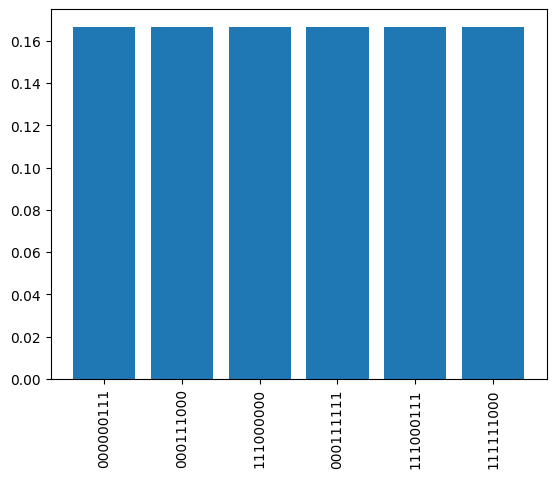

In [4]:
DATA_b3 = DiscreteProbabilityDistribution(Counter( bas.horizontal_bars()  ))

plot_bargraph_desc_order(DATA_b3)

In [5]:
# wt=hebbing_learning(bas.bas_dict['bars'])
# # creating ising model for the bas stripes only dataset
# n_spins=gridsize*gridsize
# shape_of_J=(n_spins,n_spins)
# J=-1*wt
# h=np.zeros(n_spins)
# model=IsingEnergyFunction(J,h,name=f'ising model BAS {n_spins}X{n_spins} bars only')
# #model.model_summary()

##### Prepare parameterized model

     MODEL : param_model |  beta : 1.0
Num Most Probable States : 21
Entropy : 6.266491818450897
---------------------------------------------


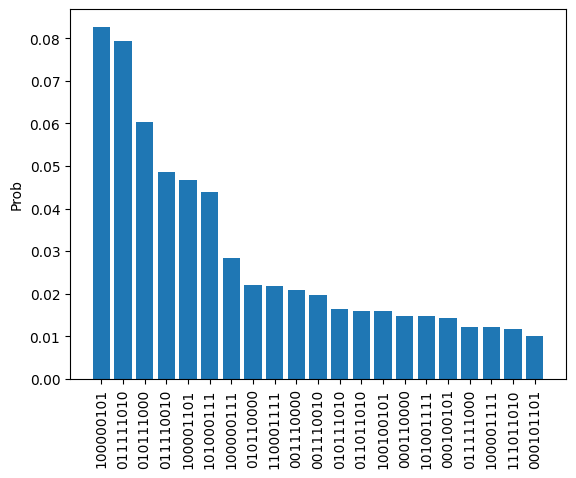

In [6]:
nspin = len(list(DATA_b3.keys())[0])
param_model = random_ising_model(nspin, 9671032, print_model= False)
beta_train = 1.0
param_model_exm = Exact_Sampling(param_model, beta= beta_train)
param_model_exm.sampling_summary()

#### TRAINING

##### MCMC Type :  Quantum 

In [15]:
## mixer -> 'qu-wt1' ##
qu_wt1 = cd_training(param_model, beta_train, DATA_b3, name= 'qu-wt1')

qu_wt1.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 1]] , [] ] },
             epochs= 10, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 1000, show_kldiv= True)

training epochs: 100%|██████████| 10/10 [00:25<00:00,  2.55s/it, mcmc_type=quantum-enhanced, kl div =1.61]


In [23]:
# mixer -> 'qu-wt3' ##
qu_wt3 = cd_training(param_model, beta_train, DATA_b3, name= 'qu-wt3')

qu_wt3.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3]] , [] ] },
             epochs= 10, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 1000, show_kldiv= True)

training epochs: 100%|██████████| 10/10 [01:21<00:00,  8.19s/it, mcmc_type=quantum-enhanced, kl div =1.53]


In [18]:
# mixer -> 'qu-alt-wt1-wt3' ##
qu_alt_wt1_wt3 = cd_training(param_model, beta_train, DATA_b3, name= 'qu-alt-wt1-wt3')

qu_alt_wt1_wt3.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3], ['random', 1]] , [0.7, 0.3] ] },
             epochs= 10, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 1000, show_kldiv= True)

training epochs: 100%|██████████| 10/10 [01:01<00:00,  6.19s/it, mcmc_type=quantum-enhanced, kl div =1.56]


In [22]:
## mixer -> 'qu-stabilizers-wt3' ##
qu_stabilizers_wt3 = cd_training(param_model, beta_train, DATA_b3, name= 'qu-stabilizers-wt3')

qu_stabilizers_wt3.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['custom', [[0,1,2], [3,4,5], [6,7,8]] ]], []] },
             epochs= 10, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 1000, show_kldiv= True)

training epochs: 100%|██████████| 10/10 [00:24<00:00,  2.50s/it, mcmc_type=quantum-enhanced, kl div =5.02]


##### MCMC Type : Classical  

In [10]:
## mixer -> 'uniform' ##
cl_uniform = cd_training(param_model, beta_train, DATA_b3)

cl_uniform.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'classical' , 'mixer' : [  [['uniform']], [] ] },
             epochs= 2, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 100, show_kldiv= True)

training epochs: 100%|██████████| 2/2 [00:00<00:00, 77.76it/s, mcmc_type=classical, kl div =4.22]


In [11]:
## mixer -> 'local-wt3' ##
cl_local_wt3 = cd_training(param_model, beta_train, DATA_b3)

cl_local_wt3.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3]], [] ] },
             epochs= 2, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 100, show_kldiv= True)

training epochs: 100%|██████████| 2/2 [00:07<00:00,  3.82s/it, mcmc_type=classical, kl div =4.32]


In [14]:
## mixer -> 'local-wt1-wt3' ##
cl_alt_wt1_wt3 = cd_training(param_model, beta_train, DATA_b3)

cl_alt_wt1_wt3.train(lr= 0.05, mcmc_settings= {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3], ['local', 1]], [0.4, 0.6] ] },
             epochs= 2, iterations= nspin, num_random_Jij= nspin, mcmc_steps= 100, show_kldiv= True)

training epochs: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it, mcmc_type=classical, kl div =4.13]


#### ANALYSIS

In [28]:
# MODEL_TRAINING_DATA = dict([ (item.name, item ) for item in l   ] )
# mcmc_types = MODEL_TRAINING_DATA.keys()

#### EXPERIMENTS

In [76]:
MCMC_SETTINGS = {
                'qu-wt1': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 1]] , [] ] },
                'qu-wt3':{'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3]] , [] ] },
                'qu-alt-wt1-wt3' : {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['random', 3], ['random', 1]] , [0.5, 0.5] ] },
                'qu-stabilizers-wt3': {'mcmc_type': 'quantum-enhanced' , 'mixer' : [ [['custom', [[0,1,2], [3,4,5], [6,7,8]] ]], []] },
                'cl-uniform': {'mcmc_type': 'classical' , 'mixer' : [  [['uniform']], [] ] }, 
                'cl-local-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3]], [] ] },
                'cl-alt-wt1-wt3': {'mcmc_type': 'classical' , 'mixer' : [  [['local', 3], ['local', 1]], [0.5, 0.5] ] } 
                }

EPOCHS = 400 
ITERATIONS = nspin
MCMC_STEPS = 1000
lr = 0.01



In [45]:
DATA_E0 = {mcmc_type: cd_training(param_model, beta_train, DATA_b3, name= mcmc_type) for mcmc_type in MCMC_SETTINGS.keys()}

In [ ]:
name = "EO.pkl"
import pickle

for mcmc_type in tqdm(MCMC_SETTINGS.keys()) :
    
    DATA_E0[mcmc_type].train(lr = lr, mcmc_settings= MCMC_SETTINGS[mcmc_type], epochs= EPOCHS, iterations= ITERATIONS, mcmc_steps= MCMC_STEPS, show_kldiv= True)  ## show_kldiv should be TRUE for training history to be stored
    with open(name, 'wb') as f:  pickle.dump(DATA_E0, f)

    

In [53]:
# name = "EO.pkl"
# import pickle

# with open(name, 'wb') as f:  pickle.dump(DATA_E0, f)

# with open(name, 'rb') as f : DATA_E0 = pickle.load(f)

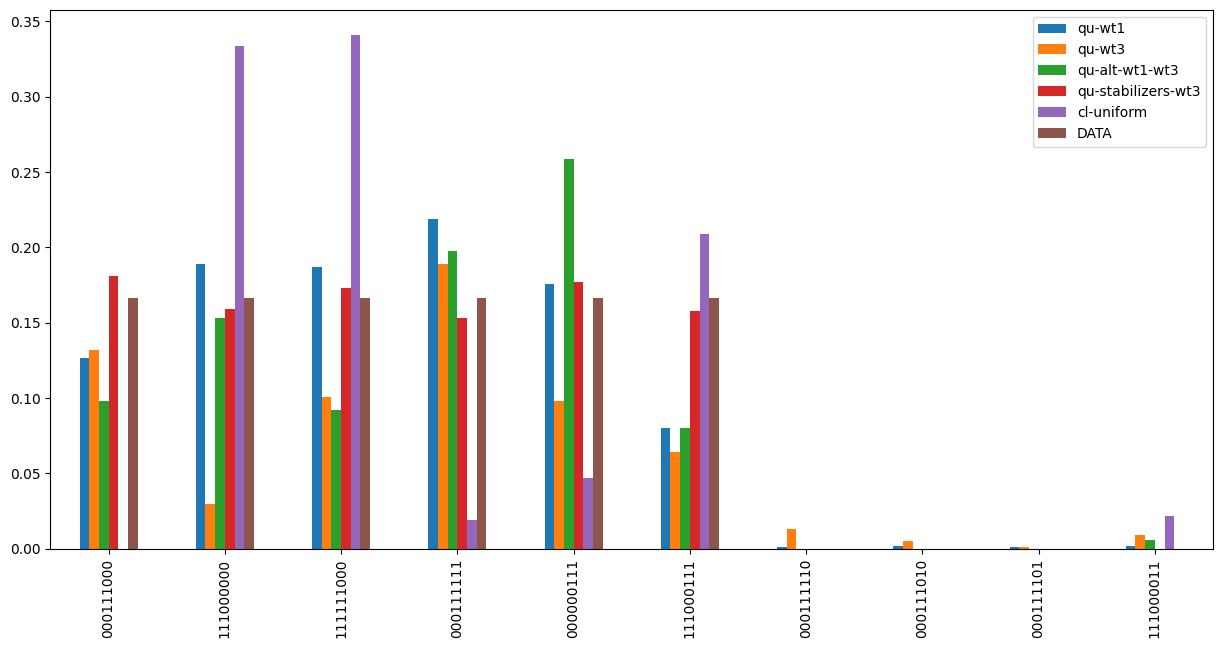

In [74]:
types_for_plot = ['qu-wt1', 'qu-wt3', 'qu-alt-wt1-wt3', 'qu-stabilizers-wt3', 'cl-uniform' ]
plot_multiple_bargraphs([ DiscreteProbabilityDistribution(dict(Counter(DATA_E0[mcmc_type].mcmc_chain.markov_chain))) for mcmc_type in types_for_plot] + [DATA_b3], types_for_plot + ['DATA'], [False]*len(types_for_plot) + [False], plot_first_few= 10)
    